In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import datasets
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets, metrics

In [8]:
postgres_user = 'postgres'
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [9]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [10]:
# Define the features and the outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)


In [11]:
# Standardize the data.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [12]:
from sklearn.cluster import KMeans
arr =[]

for i in range (1,11):
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300, n_init = 10, random_state=0)
    kmeans.fit(X_std)
    arr.append(kmeans.inertia_)

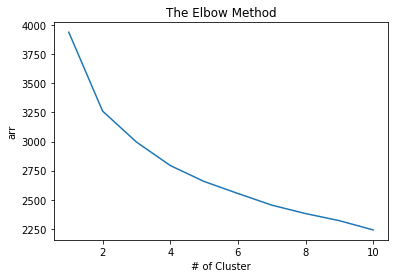

In [13]:
plt.plot(range(1,11),arr)
plt.title("The Elbow Method")
plt.xlabel( "# of Cluster")
plt.ylabel("arr")
plt.show()

In [14]:
# we will use 2 as number of clusters

In [15]:
# Reduce it to two components for visualization
X_pca = PCA(2).fit_transform(X_std)

In [16]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

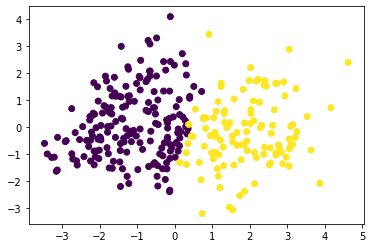

In [17]:
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [18]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0       38  151
1      101   13


Correctly classified 252 cases out of 204.

In [23]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.17530682286260937


In [39]:
metrics.adjusted_rand_score(y, y_pred)

0.4380857727169879

KMeans silhouette_score: 0.175 and ARI: 0.438

In [32]:
# Next, Defining the agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

In [34]:
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

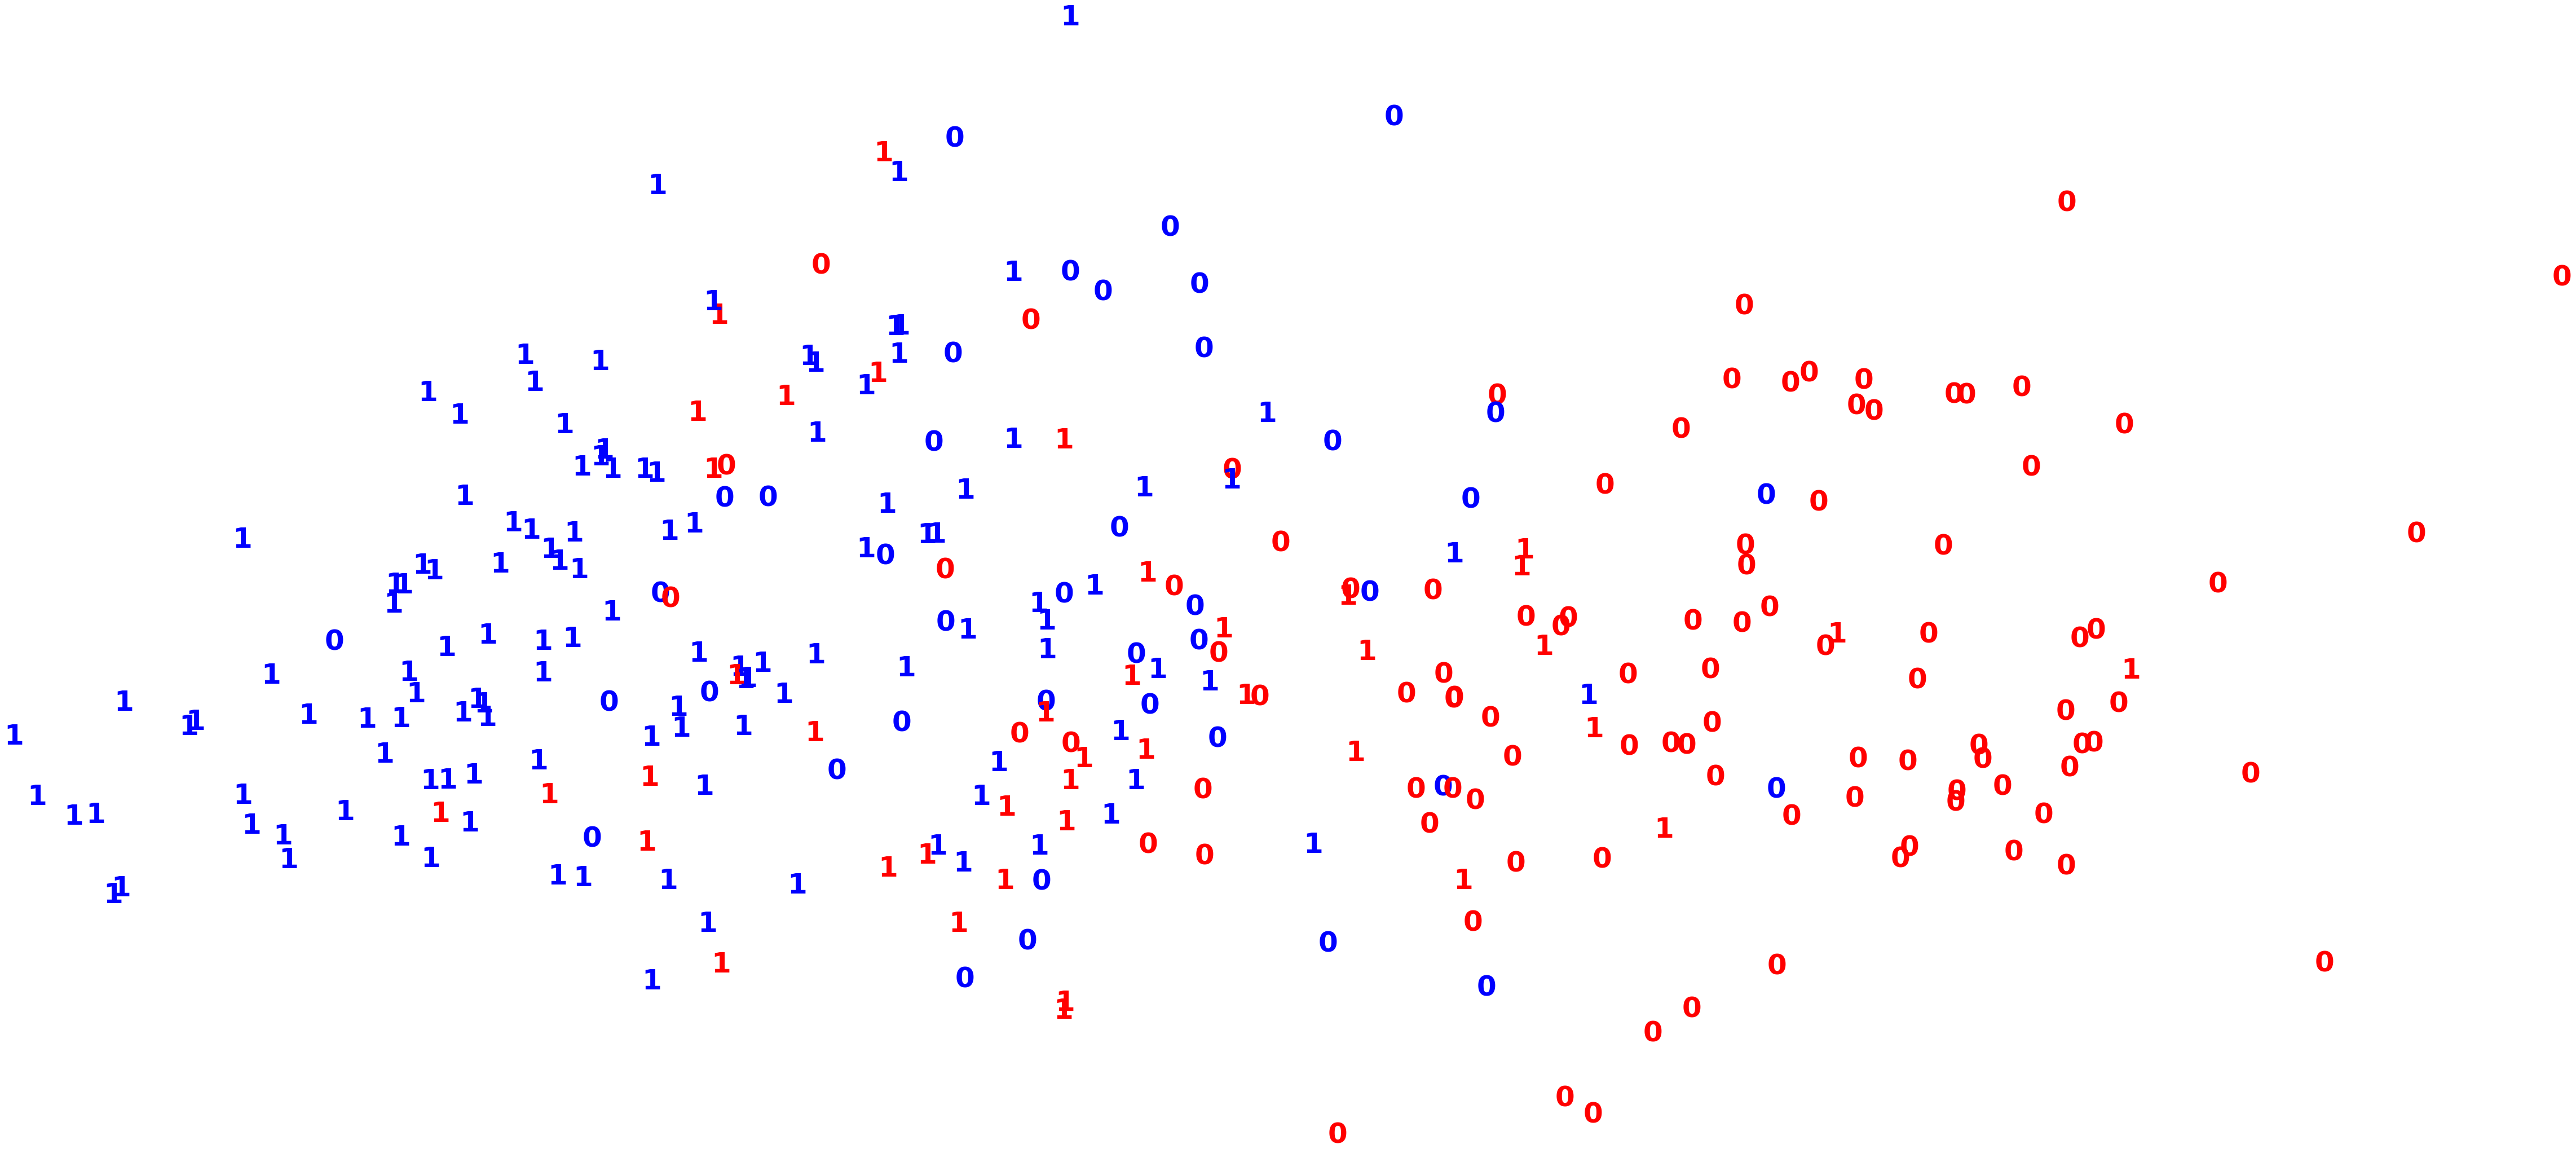

In [35]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Above,  we sketch the clusters assigned by agglomerative clustering. To be able to do that, we apply PCA to the four features we have and use the first two principal components.

In the plot above, the numbers show the cluster each observation has been assigned to by the algorithm. The colors denote the true classes.


In [36]:
# Get the Adjusted Rand Index (ARI) and the silhouette scores for the 
# agglomerative clustering approach and compare them with the 
# results for k-means from the cell:

In [37]:
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.21394030618551016
The silhoutte score of the Agglomerative Clustering solution: 0.11730765444448985


The ARI score for the Agglomerative  clustering approach is 0.213 and slightly lower than the one for k-means, which was 0.438. The silhouette score of the Agglomerative  is 0.177, which is slightly lower than that of the k-means which was 0.175. Overall, the comparison is not very decisive and both algorithms achieve more or less the same performance.

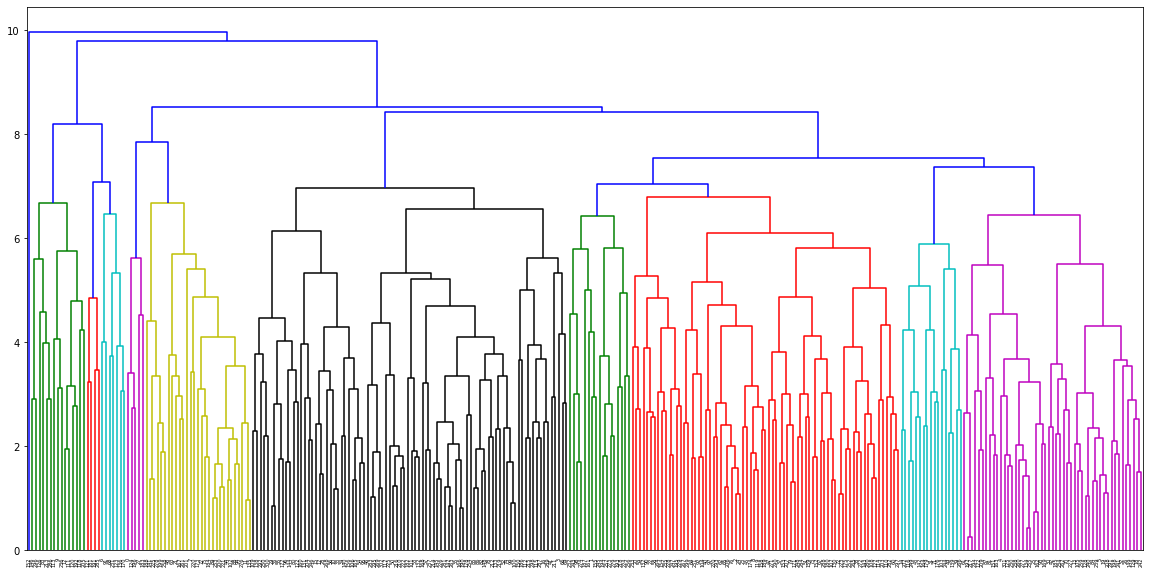

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.show()

Next, we will use the DBSCAN algorithm


In [44]:
from sklearn.cluster import DBSCAN
# Defining the DBSCAN clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

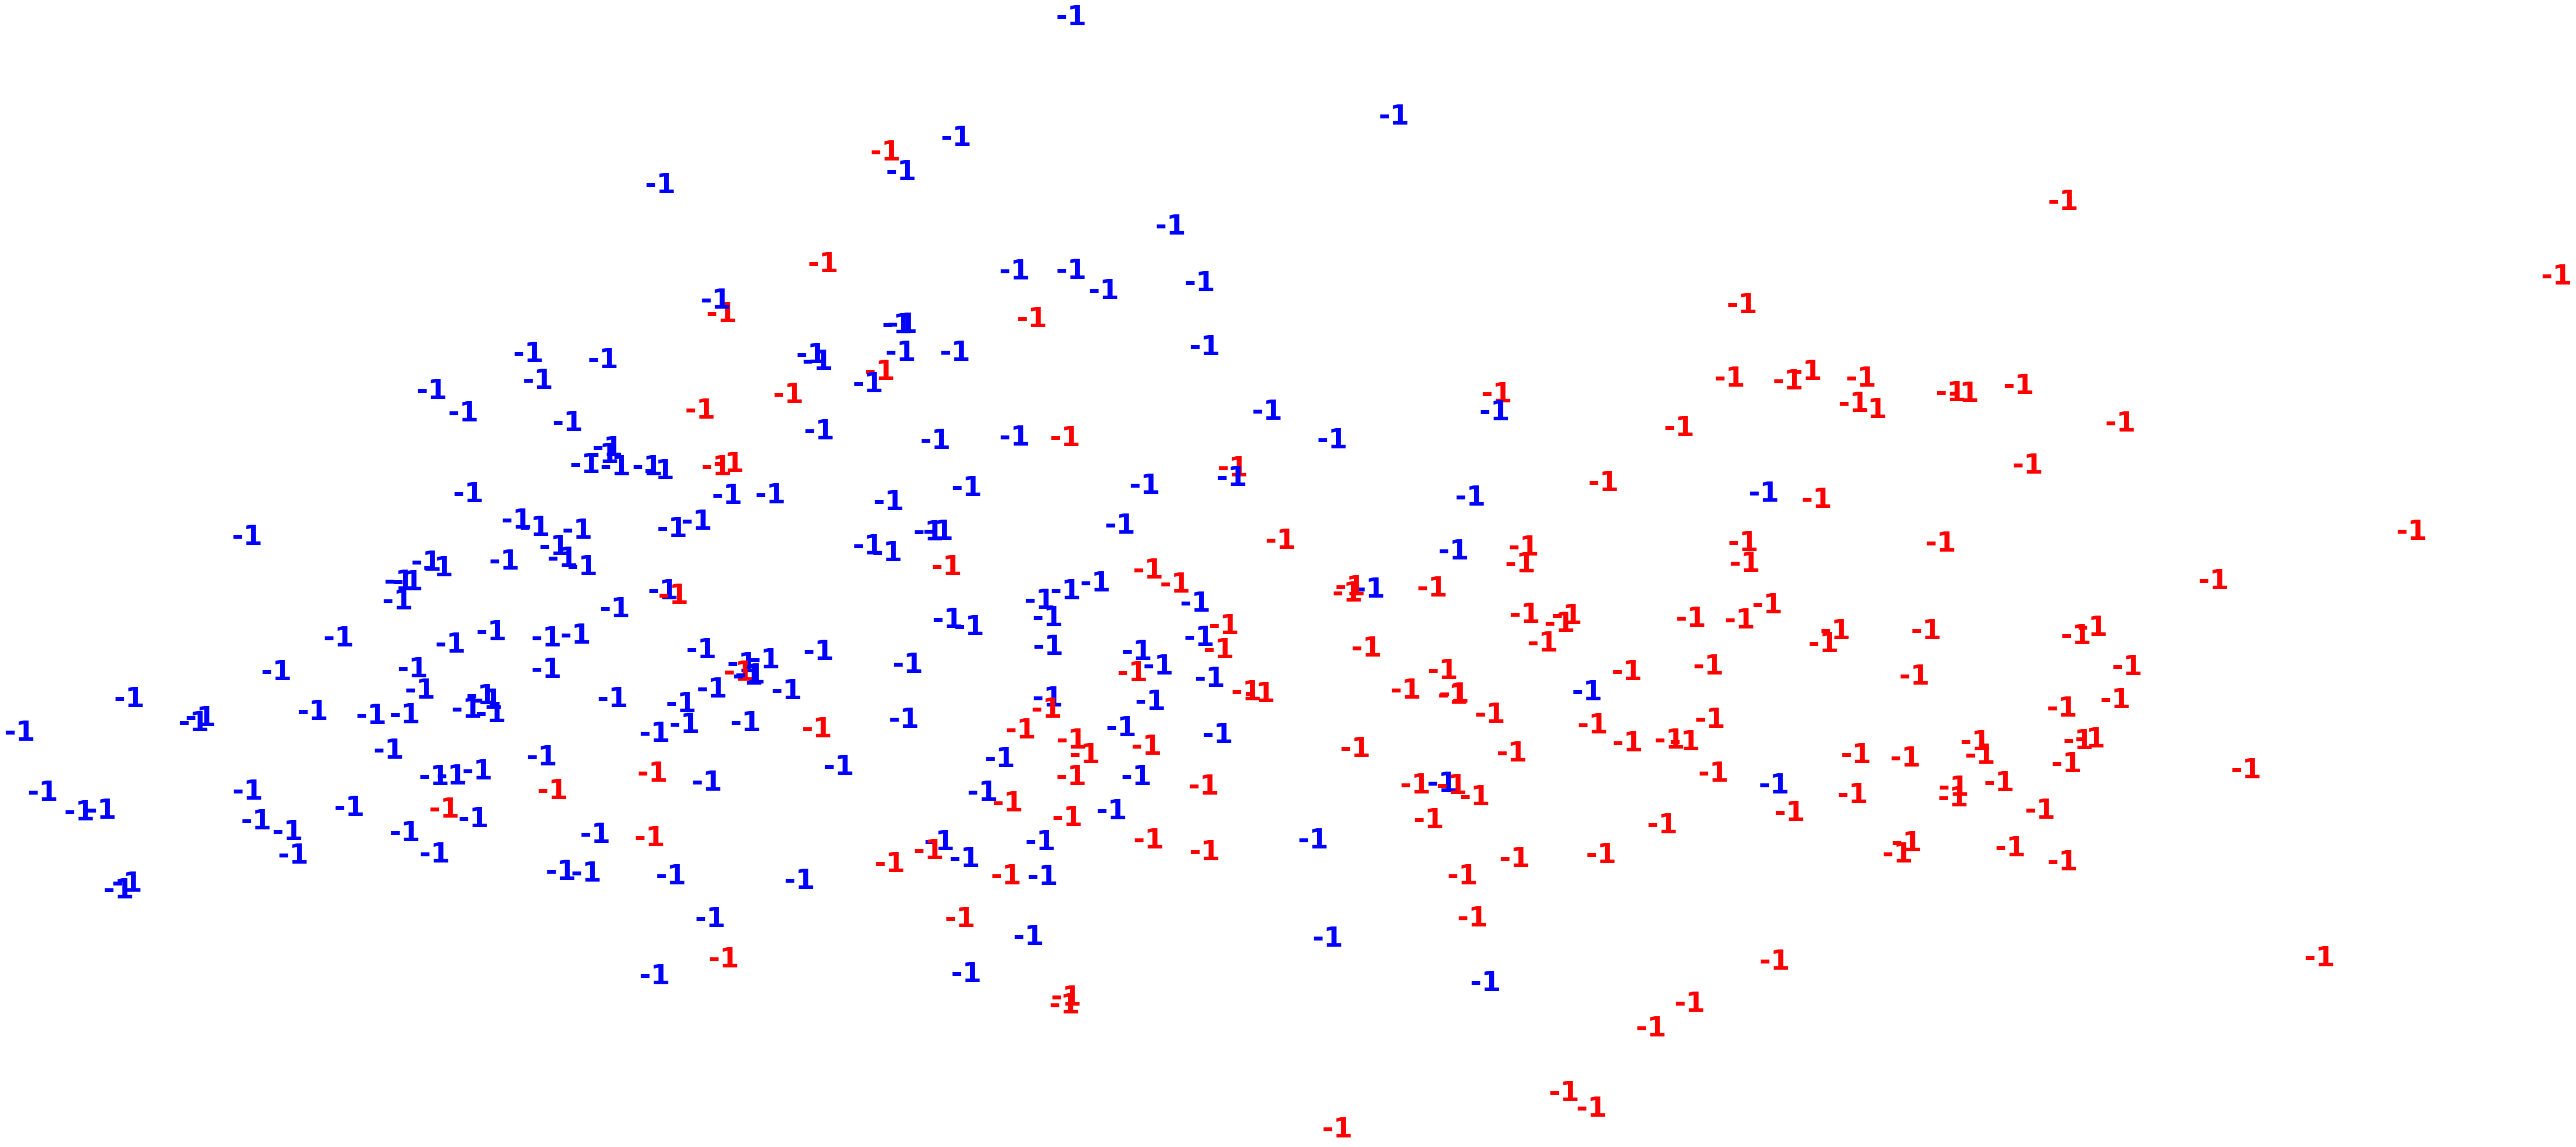

In [46]:
# visualize how DBSCAN assigned clusters to the observations by using the 
# first two principal components of our data.
pca = PCA(n_components=4).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The plot above, the numbers show the cluster each observation has been assigned to by the algorithm. The colors denote the true classes.All the observations we see labeled as -1 are actually noise and hence they don't belong to any cluster. 

In [77]:
print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y_pred, clusters)))

Adjusted Rand Index of the DBSCAN solution: 0.06020566061548398


Two clusters that DBSCAN discovers are not what we want. Actually, we see that DBSCAN couldn't distinguish between the two species that aren't linearly separable from each other. Hence, it performs worse than both k-means and hierarchical clustering. The ARI score of DBSCAN solution is lower than those of the k-means and hierarchical clustering.

In [50]:
# Next, we will use the GMM algorithm
from sklearn.mixture import GaussianMixture

In [51]:
# Defining the GMM clustering
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

To visualize the results, we apply PCA and use the first two components. In the plot below, the numbers show the cluster each observation has been assigned to by the algorithm. The colors denote the true classes.

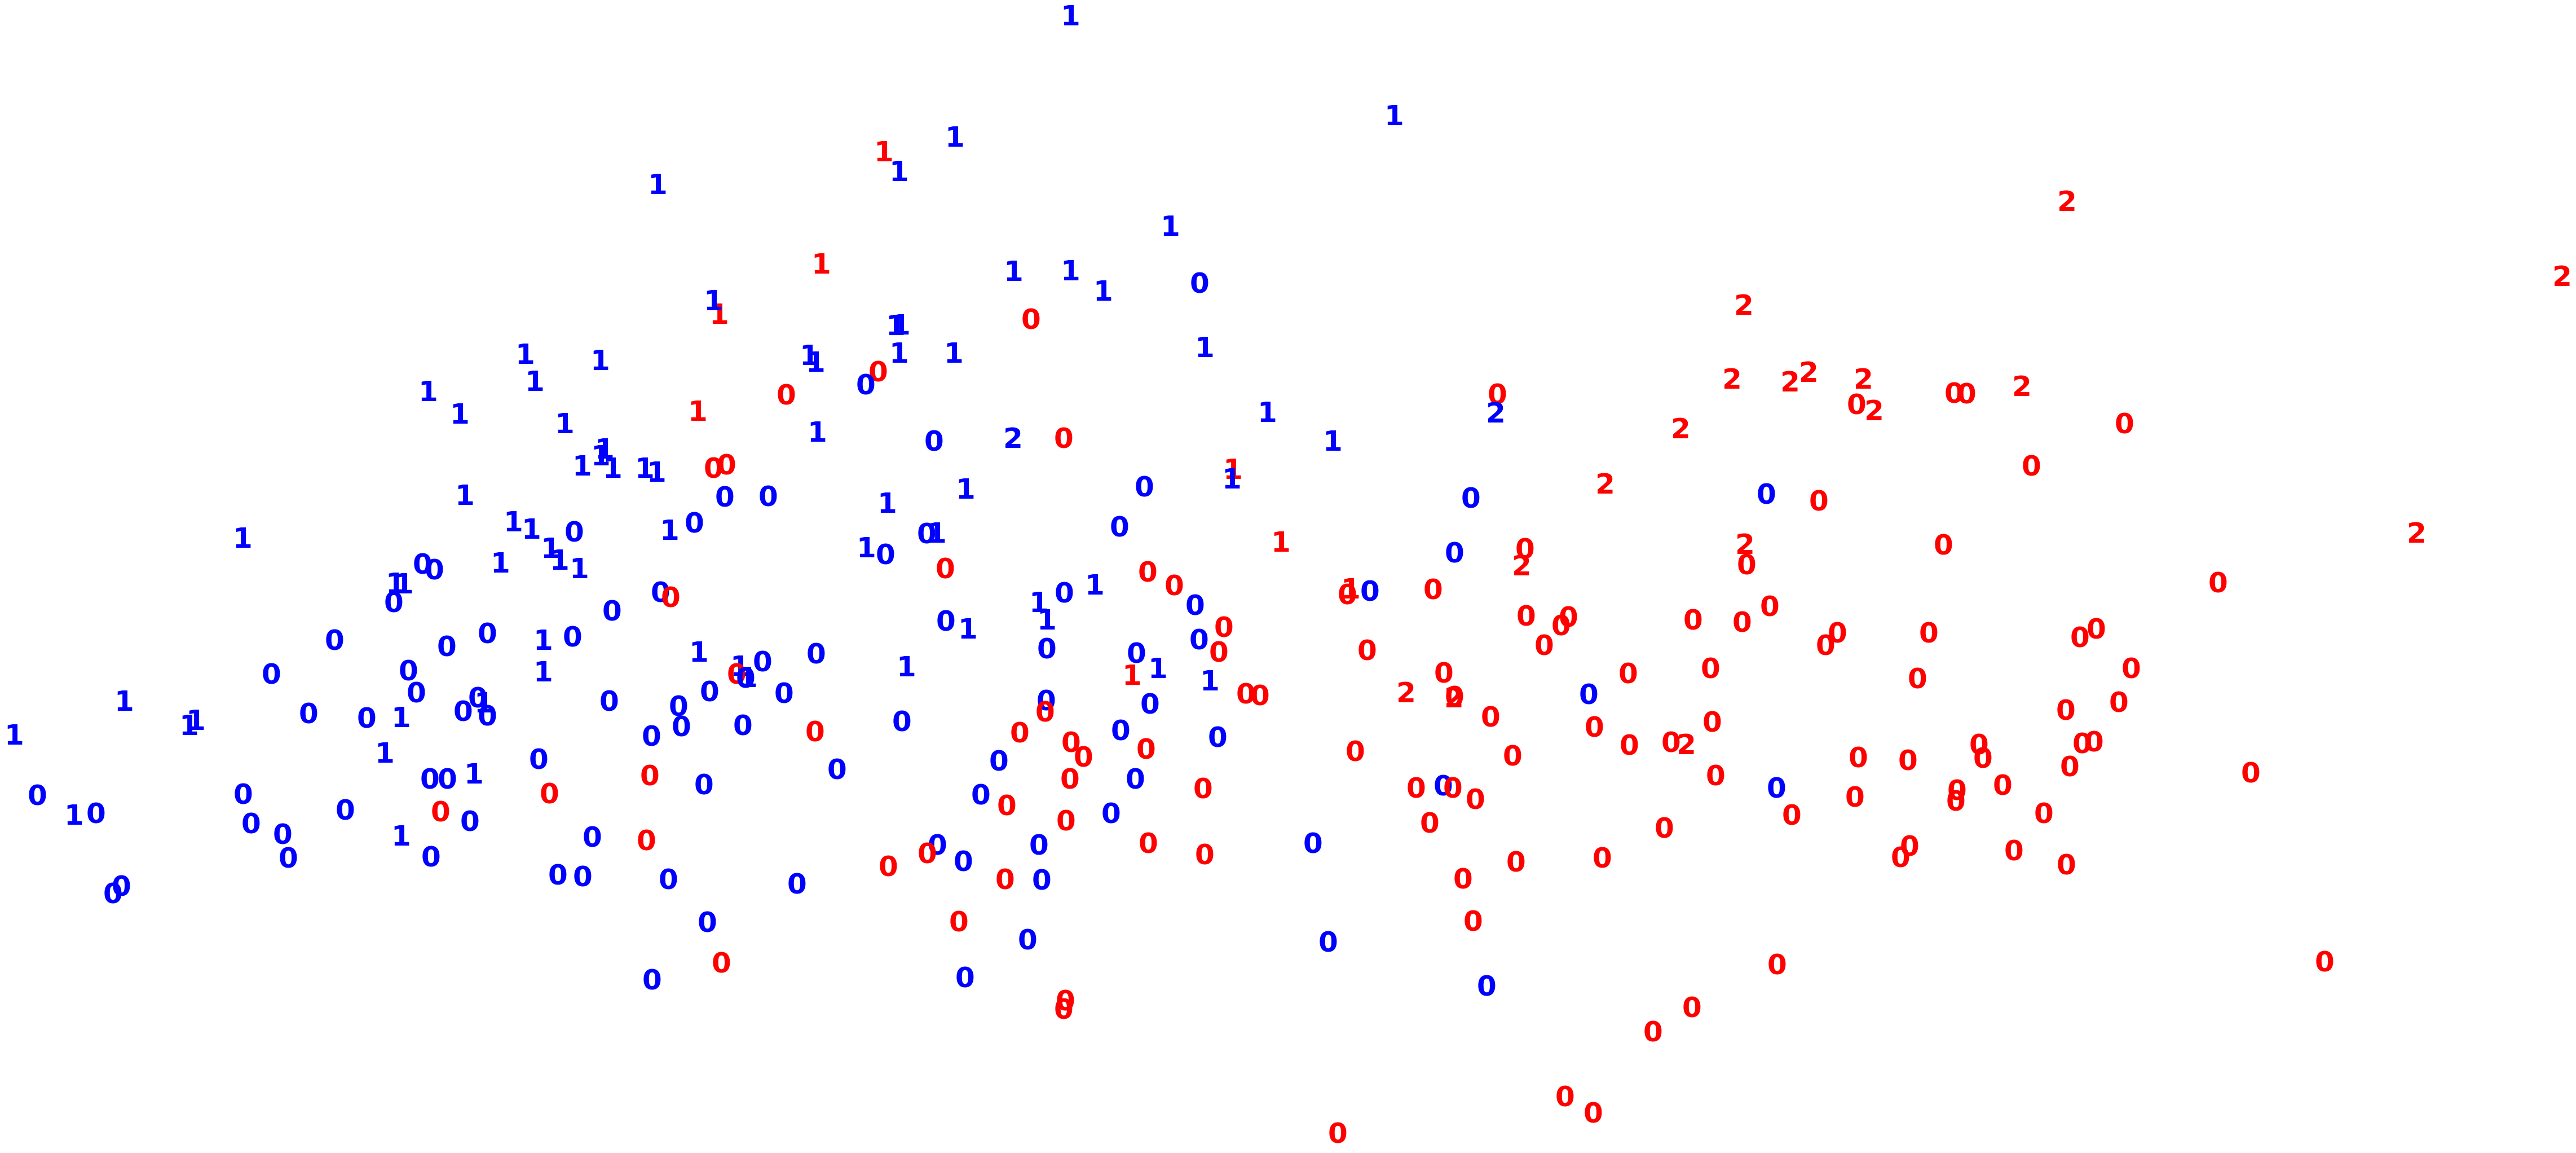

In [52]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

It seems that the GMM solution not able to separate two classes. Let's get the ARI and silhouette scores of this solution:

In [53]:
print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.08917329098922651
The silhoutte score of the GMM solution: 0.08182877824438428


GMM's ARI is 0.089 and the silhoutte score is 0.081. Both scores are very low and performed poorly compare to Hierarchical and K-mean clusterings.

Let's use PCA to visualize the data

In [54]:
from sklearn.decomposition import PCA

In [59]:
# We just want the first two principal components
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(X_std)

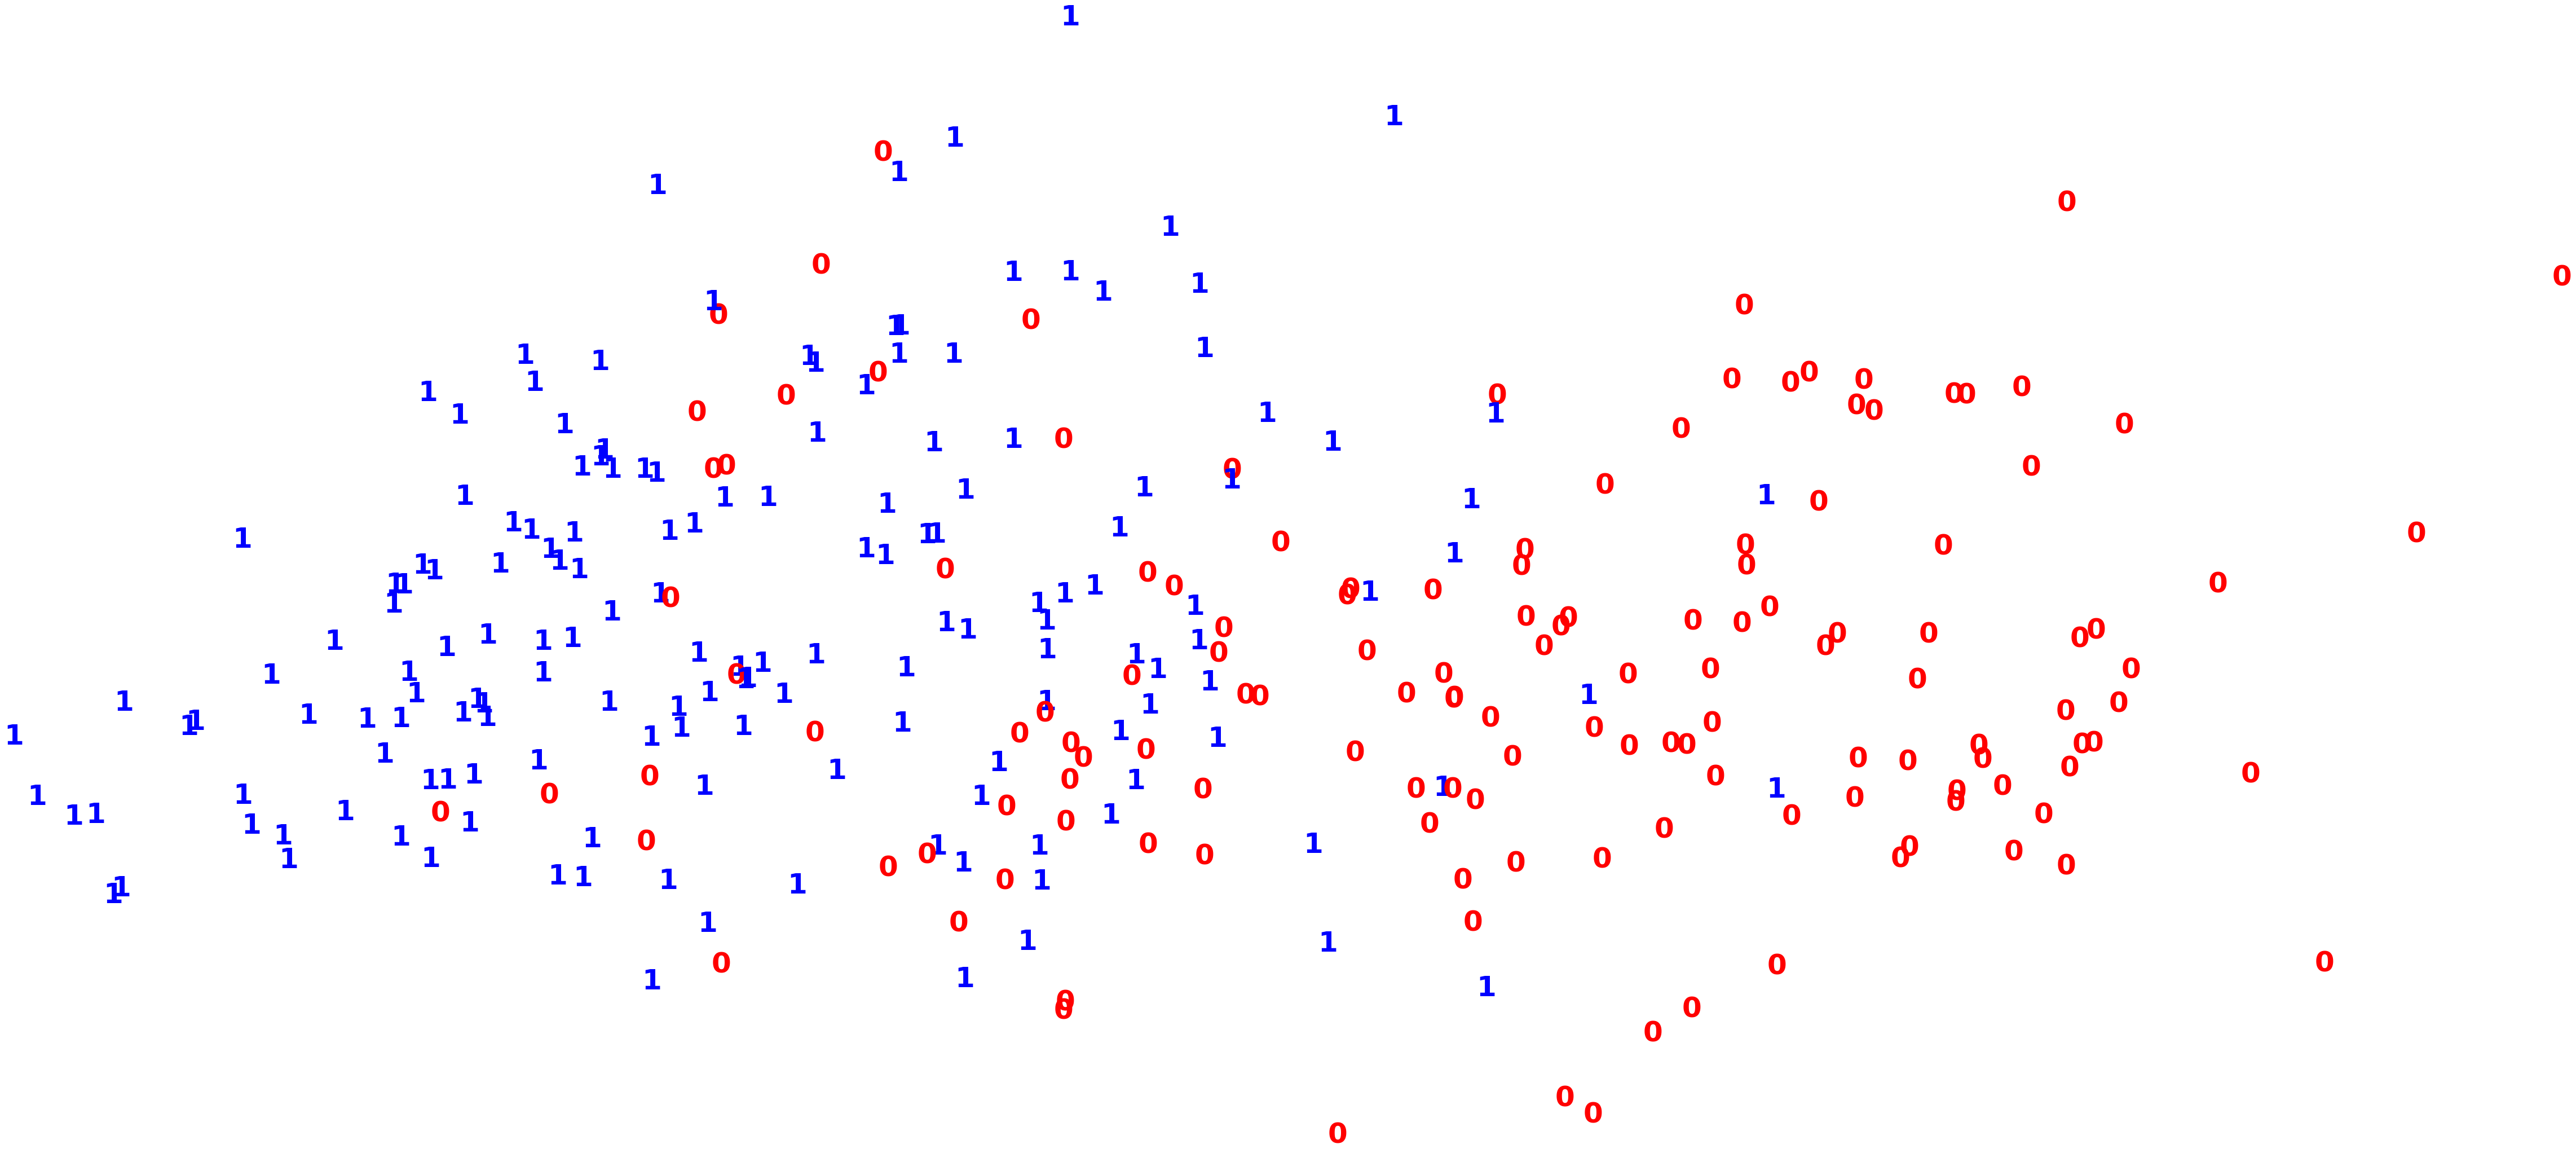

In [60]:
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(pca_components.shape[0]):
    plt.text(pca_components[i, 0], pca_components[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The graph above reveals how the two-dimensional represented  along the two axis.Most zeros occupy the right side and most ones occupying the left side. This makes sense becasue, PCA retains the global similarity structure of the data and hence dissimilar objects tend to be located far away from each other in the lower-dimensional representation. 

In [76]:
# To illustrate this, we plot the same graph above this time 
# without coloring or labeling the data points

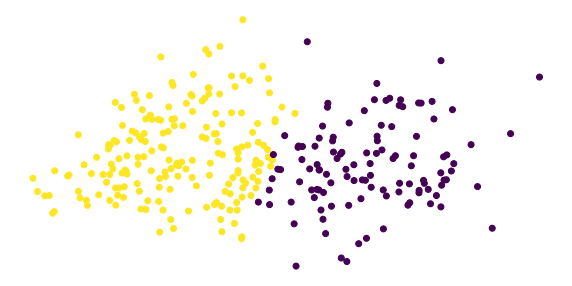

In [84]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c  = y_pred)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The plot above do not distinguish the 2 dimensions very well!

Let's try the dimension reductioon with t-SNE

In [66]:
from sklearn.manifold import TSNE
import time

In [67]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 303 samples in 0.001s...
[t-SNE] Computed neighbors for 303 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 303 / 303
[t-SNE] Mean sigma: 1.708686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.315155
[t-SNE] KL divergence after 300 iterations: 0.865241
t-SNE done! Time elapsed: 0.8030233383178711 seconds


Now, we can plot our data using the t-SNE components. In the figure below, we colored and labeled each data point according to its true digit to help our understanding of how useful t-SNE representions are:

In [71]:
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 80}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

 Digit classes seem to be separated from each other better in this plot. This is because of the fact that t-SNE preserves the local similarities. Since the observations that belong to the same digit class are similar to each other, in the two-dimensional representation of t-SNE we see them clustered together.

In [73]:
# To illustrate this, we plot the same graph above this time without coloring 
# or labeling the data points

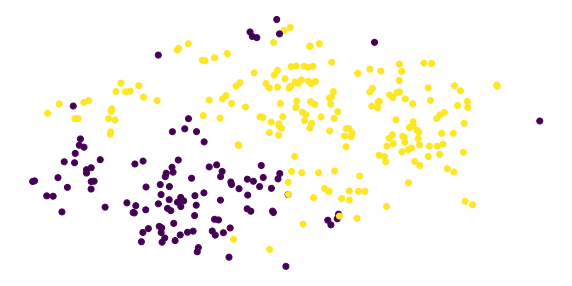

In [83]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c  = y_pred )
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Conclusion: Unsupervised learning can be useful but at the same tricky. The algorithms difficult to understand due the the nature of the dataset. Clustering and dimensionality reduction is very useful organizing samples into groups and reduce the dimensionality so that we can visualize it.
In this assignment, we can conclude that, K-means clustering algorithm performed better than others tested. Also, t-SNE dimensionality reduction provided better result than DBSCAN.